# Trabalho Prático 1: Geometria Computacional

Filipe Pirola Santos - 2021031580

Igor Eduardo Martins Braga - 2022425671

Wallace Eduardo Pereira - 2021032013

# Bibliotecas


In [98]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Algoritmos

**Algoritmo de envoltória convexa**

Para construir a envoltória convexa, utilizamos o algoritmo de Graham. Seguimos a ideia vista em sala de aula, onde primeiro calculamos o âncora, ou seja, o ponto com a menor coordenada y e, caso houver empate, aquele mais à esquerda. Em seguida, o algoritmo ordena os demais pontos com respeito ao ângulo polar em relação ao âncora. Percorremos a lista ordenada removendo os pontos que que formam uma "curva para a direita". A partir disso, temos a envoltória convexa.

Decidimos escolher esse algoritmo por ser mais eficiente, ao utilizar a ideia de ordenar os pontos. Assim, essa lista é calulada uma vez e percorremos-a uma unica vez para calcular a envoltória convexa.

In [4]:
## @brief Calcula a orientação dos pontos
## @param q, p, r Pontos no plano
def orientation(p, q, r):

    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

    if val == 0:
        return 0  # Os pontos são colineares

    return 1 if val > 0 else 2  # Orientação horária ou antihorária

In [5]:
## @brief Calcula a envoltória convexa utilizando o algoritmo de Graham
## @param pontos Conjunto de pontos analisados
def getConvexHull(points):

    n = len(points)

    # Caso só tenham 3 pontos, então eles formam a envoltória
    if n < 3:
        return points

    # Encontrar o ponto com a menor coordenada y (e mais à esquerda, se houver empate) (âncora)
    pivot = min(points, key=lambda x: (x[1], x[0]))

    # Ordenar os pontos com base no ângulo polar em relação ao âncora
    sortedPoints = sorted(points, key=lambda x: (math.atan2(x[1] - pivot[1], x[0] - pivot[0]), x))

    p1 = sortedPoints[0]
    p2 = sortedPoints[1]

    # Inicializar a envoltória convexa com a âncora e os dois primeiros pontos ordenados
    convexHull = [pivot, p1, p2]

    # Iterar pelos pontos ordenados para encontrar a envoltória convexa
    for i in range(2, n):
        while len(convexHull) > 1 and orientation(convexHull[-2], convexHull[-1], sortedPoints[i]) != 2:
            convexHull.pop()
        convexHull.append(sortedPoints[i])

    return convexHull

**Algoritmo de Varredura Linear**

Para verificar se dois segmentos se interceptam podemos analisar se eles cruzam as retas que os sobrepõem. Contudo, se verificarmos que algum dos pontos entre dois segmentos são colineares, então devemos avaliar se o ponto sobrepõe o segmento analisado. Para isso, basta verificar se as coordenadas estão dentro do intervalo definido pelos dois terminais do segmento.

In [6]:
def on_segment(p, q, r):
    # Verifique se o ponto q está no segmento formado por p e r
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

def do_segments_intersect(p1, q1, p2, q2):
    # Verifica se os segmentos p1q1 e p2q2 se intersectam
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # Casos gerais
    if o1 != o2 and o3 != o4:
        return True

    # Casos especiais
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def any_segments_intersect(segments):
    n = len(segments)
    for i in range(n):
        for j in range(i + 1, n):
            if do_segments_intersect(segments[i][0], segments[i][1], segments[j][0], segments[j][1]):
                return True
    return False

**Separabilidade linear**

Com a envoltória convexa calculada para o grupo A e para o grupo B de dados, podemos analisar se não há interseção entre os elementos do conjunto, ou seja, se os dados são *linearmente separáveis*.

Para isso seguimos os seguintes passos. Primeiramente, pegamos o conjunto de pontos das duas envoltórias e encontramos os segmentos que a formam. Em segundo lugar, aplicamos o algoritmo de varredura linear entre os segmentos dos dois grupos caso exista uma interseção, então os dados não são linearmente separáveis e não podem ser usados no nosso modelo.

In [7]:
## Implementação do FILIPE

# Função para verificar a interseção entre duas envoltórias convexas
def separavelLinear(convexHullA, convexHullB):
    nA = len(convexHullA)
    nB = len(convexHullB)
    for i in range(nA):
        for j in range(nB):
            if do_intersect(convexHullA[i], convexHullA[(i + 1) % nA], convexHullB[j], convexHullB[(j + 1) % nB]):
                return False
    return True

# Função para verificar se dois segmentos de linha se intersectam
def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False

# **Modelo**

Após decidir se os dados são linearmente separáveis, podemos construir um modelo para classificar novos valores do conjunto.

**Pontos mais próximos da envoltória**

Em primeiro lugar, vamos encontrar o par de pontos mais próximos entre as duas
envoltórias convexas calculadas. Para isso, criamos a função *closest_points_between_convex_hulls* que utiliza loops aninhados para comparar todas as combinações possíveis de pontos e a função *squared_distance* para calcular as distâncias. É importante notar que a distância real não é retornada, apenas o par de pontos e o quadrado da distância euclidiana.

In [8]:
## @brief Calcula a distancia euclidiana entre um par de pontos
## @param point_1, point_2 Par de pontos
def squaredDistance(pointA, pointB):
  x1, y1 = pointA
  x2, y2 = pointB
  return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [9]:
## @brief Encontra o par de pontos mais próximo entre as duas envoltórias
## @param convex_hull_1, convex_hull_2 Envoltórias convexas
def getClosestPair(convexHullA, convexHullB):
  closestPair = None
  closestDistance = float('inf')

  for pointA in convexHullA:
    for pointB in convexHullB:
      distance = squaredDistance(pointA, pointB)
      if distance < closestDistance:
        closestPair = (pointA, pointB)
        closestDistance = distance

  return closestPair

**Reta que divide os dois grupos**

Após encontrar os dois pontos mais próximos entre as envoltórias, nosso próximo passo é calcular a reta perpendicular ao segmento formado pelo par de pontos. Para isso, vamos usar a função *find_perpendicular_bisector* para encontrar os pontos pertencentes a reta e, em seguida, a função *find_equation_of_line* para encontrar a equação que define essa reta.

In [10]:
## @brief Calcula os parâmetros da reta gerada por um par de pontos
## @param x1, y1, x2, y2 Coordenadas cartersianas de um par de pontos
def getLinearEquation(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return a, b

In [11]:
## @brief Encontra a reta bissetriz entre um par de pontos
## @param x1, y1, x2, y2 Coordenadas cartersianas de um par de pontos
def getBisector(x1, y1, x2, y2):
    # Encontrar o ponto médio do segmento
    midpointX = (x1 + x2) / 2
    midpointY = (y1 + y2) / 2

    # Calcular o vetor direção do segmento AB
    ABX = x2 - x1
    ABY = y2 - y1

    # Calcular o vetor direção da reta bissetriz
    bissetorX = -ABY
    bissetorY = ABX

    # Normalizar o vetor bissetriz
    length = np.sqrt(bissetorX**2 + bissetorY**2)
    bissetorX /= length
    bissetorY /= length

    # Definir os pontos finais da bissetriz
    length = 5  # Comprimento da reta bissetriz
    endPointAX = midpointX - length * bissetorX
    endPointAY = midpointY - length * bissetorY
    endPointBX = midpointX + length * bissetorX
    endPointBY = midpointY + length * bissetorY

    return getLinearEquation(endPointAX, endPointAY, endPointBX, endPointBY)

**Classificar os pontos**

Por fim, precisamos classificar os pontos com base no modelo encontrado. Assim, vamos receber um conjunto de novos pontos e, com a equação da reta encontrada, podemos definir qual a posição deles em relação ao modelo, classificando-os com valores selecionados.

In [12]:
## @brief Classifica um conjunto de pontos em relação a uma reta modelo
## @param a, b Parâmetros da reta modelo
##        point Conjunto de pontos a ser classificado
def classifyData(a, b, point):
  # Inicializar listas para classificação e cores
  colors = []

  # Classificar e atribuir cores aos pontos
  for x, y in point:
      y_expected = a * x + b
      if y > y_expected:
          colors.append('blue')
      elif y < y_expected:
          colors.append('red')
      else:
          colors.append('orange')

  return colors

**Função geral**

Com essa função, é possível obter a classificação para os novos dados, com base nos dois grupos utilizados como parâmetro.

In [13]:
## @brief Realiza os passos necessários para o trabalho funcionar
## @param groupA, groupB Amostras usadas para criar o modelo
##        newGroup Amostrar usadas para testar o modelo
def main(groupA, groupB, newGroup, groupnameA, groupnameB):

  # Encontrar a envoltória convexa dos pontos
  convexHullA = getConvexHull(groupA)
  convexHullB = getConvexHull(groupB)

  # Checa se os grupos são linearmente separáveis
  if separavelLinear(convexHullA, convexHullB):

    # Encontra os dois pontos mais próximos da envoltória
    closestPair = getClosestPair(convexHullA, convexHullB)
    (cx1, cy1), (cx2, cy2) = closestPair

    # Gera o modelo que descreve os dados
    a, b = getBisector(cx1, cy1, cx2, cy2)

    # Classifica os novos pontos
    #colors = classifyData(a, b, newGroup)

    # Checa a acurácia do modelo
    # Código aqui

    # Imprime o modelo
    plotModel(convexHullA, convexHullB, closestPair, groupnameA, groupnameB)

  else:
    print("Os dados não são separáveis linearmente.")

**Função auxiliar para plotar o modelo, usada no exemplo**

In [50]:
def plotModel(convexHullA, convexHullB, closestPair, nameGroup1, nameGroup2):

  # Plotar os pontos que formam a envoltória
  plt.scatter(*zip(*convexHullA), label=nameGroup1, c='b', marker='o')
  plt.scatter(*zip(*convexHullB), label=nameGroup2, c='r', marker='x')

  # Plotar a envoltória convexa em si
  xA, yA = zip(*convexHullA)
  xB, yB = zip(*convexHullB)
  plt.plot(xA + (xA[0],), yA + (yA[0],), c='g', linewidth=1)
  plt.plot(xB + (xB[0],), yB + (yB[0],), c='g', linewidth=1)

  # Plotar os pontos mais próximos destacados
  (x1, y1), (x2, y2) = closestPair
  plt.plot([x1, x2], [y1, y2], marker="o", markersize=10)

  # Plotar a reda que divide os dois grupos (bissetriz)
  a, b = getBisector(x1, y1, x2, y2)
  x_line = [x1, x2]
  y_line = [a * x + b for x in x_line]
  plt.plot(x_line, y_line, label=f'y = {m:.2f}x + {b:.2f}', color='orange')

  plt.title('Modelo para classificação dos dados')
  plt.legend()
  plt.grid(True)
  plt.show()

# Exemplo

Vamos gerar um conjunto de pontos simples linearmente separáveis simples para tornar mais fácil a compreensão dos algoritmos implementados.


**Gera pontos 40 pontos linearmente separáveis**

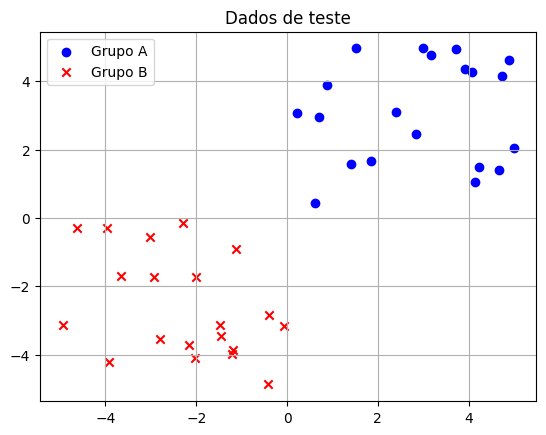

In [51]:
# Geramos 40 pontos aleatórios linearmente separáveis
groupA = [(random.uniform(0, 5), random.uniform(0, 5)) for _ in range(20)]
groupB = [(random.uniform(-5, 0), random.uniform(-5, 0)) for _ in range(20)]

# Plotamos o gráfico
plt.title('Dados de teste')
plt.scatter(*zip(*groupA), label='Grupo A', c='b', marker='o')
plt.scatter(*zip(*groupB), label='Grupo B', c='r', marker='x')
plt.legend()
plt.grid(True)
plt.show()

**Calcula a envoltória convexa dos grupos**

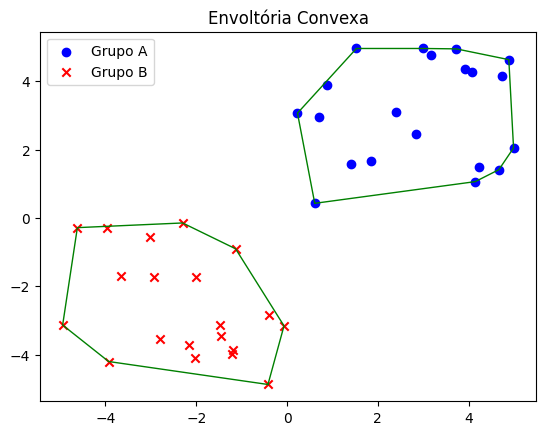

In [52]:
# Encontrar a envoltória convexa dos pontos
convexHullA = getConvexHull(groupA)
convexHullB = getConvexHull(groupB)

# Separar coordenadas x e y para plotagem
xA, yA = zip(*convexHullA)
xB, yB = zip(*convexHullB)

# Plotar os pontos de entrada
plt.scatter(*zip(*groupA), label='Grupo A', c='b', marker='o')
plt.scatter(*zip(*groupB), label='Grupo B', c='r', marker='x')

# Plotar a envoltória convexa
plt.plot(xA + (xA[0],), yA + (yA[0],), c='g', linewidth=1)
plt.plot(xB + (xB[0],), yB + (yB[0],), c='g', linewidth=1)

plt.title('Envoltória Convexa')
plt.legend()
plt.show()

**Testa se os grupos são linearmente separáveis**

In [48]:
if separavelLinear(convexHullA, convexHullB):
    print("Não há interseções entre os conjuntos A e B.")
else:
    print("Há interseções entre os conjuntos A e B.")

Não há interseções entre os conjuntos A e B.


**Encontra o modelo para classificar futuros pontos**

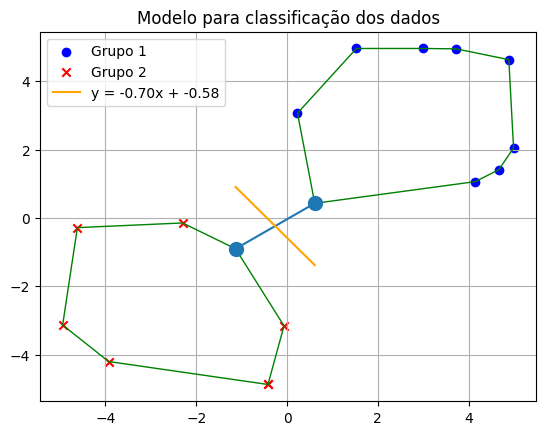

In [53]:
closestPair = getClosestPair(convexHullA, convexHullB)
plotModel(convexHullA, convexHullB, closestPair, "Grupo 1", "Grupo 2")

**Classifica os pontos**

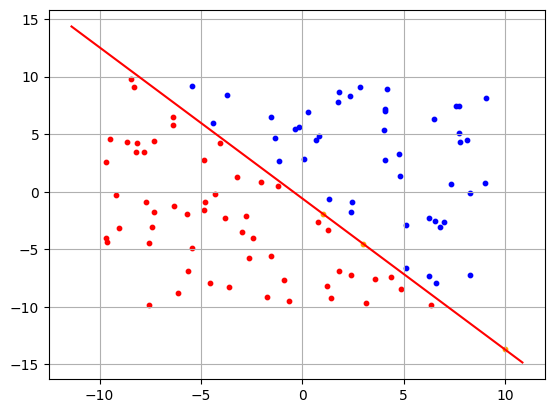

In [54]:
# Gera 100 pontos aleatórios espalhados pelo plano cartesiano
test_group = [(random.uniform(-10, 10), random.uniform(-10, 10)) for _ in range(100)]

# Dados do problema
(x1, y1), (x2, y2) = closestPair
m, b = getBisector(x1, y1, x2, y2)

# Pontos de teste sobre a reta
test_group = test_group + [(1, m + b)] + [(3, 3*m + b)] + [(10, 10*m + b)]

# Classifica os pontos
colors = classifyData(m, b, test_group)

# Plotar a reta
x_line = [x1 - 12, x2 + 12]
y_line = [m * x + b for x in x_line]
plt.plot(x_line, y_line, color='red')

# Plotar os pontos classificados com cores diferentes
for i, (x, y) in enumerate(test_group):
    plt.scatter(x, y, color=colors[i], s=10)

plt.grid(True)
plt.show()

#Limpando e plotando DataSets

SVD Completa:

Completa: A SVD completa é uma técnica matemática que fatora uma matriz em três outras matrizes, resultando em todos os valores singulares da matriz original. Em outras palavras, não há perda de informações na SVD completa.
Computacionalmente Intensiva: A SVD completa é computacionalmente intensiva, especialmente para grandes conjuntos de dados, porque envolve todas as singularidades, mesmo aquelas que podem ter valores muito pequenos e próximos a zero.

SVD Truncado (Truncated SVD):

Truncado: O SVD truncado é uma versão aproximada da SVD completa, onde algumas singularidades (valores singulares e vetores singulares) são truncadas, ou seja, são deixadas de fora do cálculo. A redução do número de singularidades resulta em uma aproximação da matriz original com menor dimensionalidade.
Eficiência Computacional: O SVD truncado é computacionalmente mais eficiente, especialmente para grandes conjuntos de dados, porque envolve apenas as singularidades mais significativas, ignorando as que contribuem menos para a variabilidade dos dados.

Diferenças em Contextos Práticos:

Uso em Redução de Dimensionalidade: O SVD truncado é frequentemente usado para redução de dimensionalidade em tarefas como mineração de texto (LSA), recomendação de filmes (filtragem colaborativa), etc. A redução de dimensionalidade é útil para lidar com a maldição da dimensionalidade, economizar espaço de armazenamento e melhorar a eficiência computacional.
Uso em Reconstrução de Matrizes: O SVD completo é útil quando você precisa reconstruir exatamente a matriz original a partir das suas componentes singulares. Isso é importante em certas aplicações científicas e matemáticas.


No contexto de análise de dados e visualização, especialmente para conjuntos de dados como o Iris, onde a redução de dimensionalidade pode ajudar a visualizar os dados em gráficos bidimensionais, o SVD truncado (Truncated SVD) é geralmente preferível. Aqui estão algumas razões pelas quais o Truncated SVD é muitas vezes escolhido para análise de dados e visualização:

Eficiência Computacional: O Truncated SVD é mais eficiente computacionalmente, especialmente quando lidamos com grandes conjuntos de dados. Ele permite reduzir a dimensionalidade sem a necessidade de calcular todas as singularidades da matriz original, o que economiza tempo de computação.

Redução de Dimensionalidade: O Truncated SVD é especificamente projetado para redução de dimensionalidade. Ele captura as direções nos dados que têm a maior variabilidade e, ao truncar os valores e vetores singulares menos importantes, permite representar os dados em um espaço de dimensões reduzidas. Isso é ideal para visualização em gráficos 2D ou 3D.

Preservação de Estruturas Importantes: O Truncated SVD tende a preservar estruturas semânticas dos dados. Em muitos conjuntos de dados, as informações mais importantes podem ser capturadas pelos primeiros componentes principais, e é isso que o Truncated SVD retém.

Facilidade de Interpretação: Ao reduzir os dados para duas ou três dimensões usando o Truncated SVD, os resultados podem ser visualizados em gráficos de dispersão ou gráficos 3D, o que é muito mais fácil de interpretar e entender do que dados em alta dimensionalidade.

Para o conjunto de dados Iris, que é relativamente pequeno e não esparsamente distribuído, você pode usar tanto PCA quanto a Truncated SVD para redução de dimensionalidade para fins de análise gráfica. Ambas as técnicas são apropriadas neste caso, e a escolha entre elas dependerá das suas necessidades específicas e preferências. No entanto, se o seu objetivo principal é a análise gráfica, PCA é geralmente a escolha mais comum e intuitiva.

Razões para Escolher PCA para a Análise Gráfica do Conjunto de Dados Iris:

Interpretabilidade: As componentes principais geradas pelo PCA podem ser interpretadas mais facilmente, pois são combinações lineares dos recursos originais. Isso é útil quando você deseja entender quais características contribuem mais para a variação nos dados.

Visualização Intuitiva: As duas primeiras componentes principais do PCA podem ser facilmente visualizadas em um gráfico bidimensional, permitindo que você visualize os dados em um espaço reduzido e identifique padrões ou agrupamentos.

Amplamente Utilizado: PCA é uma técnica de redução de dimensionalidade amplamente utilizada e compreendida, tornando mais fácil para outros analisarem e interpretarem seus resultados.

Preservação da Variância: PCA preserva a máxima variância possível nos dados originais quando projeta os dados em um espaço de dimensionalidade inferior. Isso significa que as relações entre os pontos de dados são preservadas tanto quanto possível.

Portanto, para análise gráfica do conjunto de dados Iris, recomenda-se usar PCA para reduzir a dimensionalidade para 2 ou 3 componentes principais e, em seguida, visualizar os dados em um gráfico de dispersão (scatter plot) ou em um gráfico tridimensional, se estiver usando três componentes principais. Isso ajudará a ter uma compreensão visual dos padrões nos dados e das relações entre as diferentes classes de flores Iris.

**Função de plotagem dos gráficos**

In [334]:
def plot_scatter(dataframe, legenda):

    sns.scatterplot(data=dataframe, x='X', y='Y', hue='Class', alpha=0.6, palette="deep")

    plt.xlabel('X')
    plt.ylabel('Y')
    if(legenda == 1):
      plt.legend()

    plt.show()

**Função de redução de dimensão do dataset**

In [326]:
def reduce_dimension_dataset(data):
  pca = PCA(n_components=2)
  data = StandardScaler().fit_transform(data)
  componentes = pca.fit_transform(data)
  two_dimensional_df = pd.DataFrame(data=componentes, columns=["X","Y"])

  return two_dimensional_df

## Dataset Iris - Separável

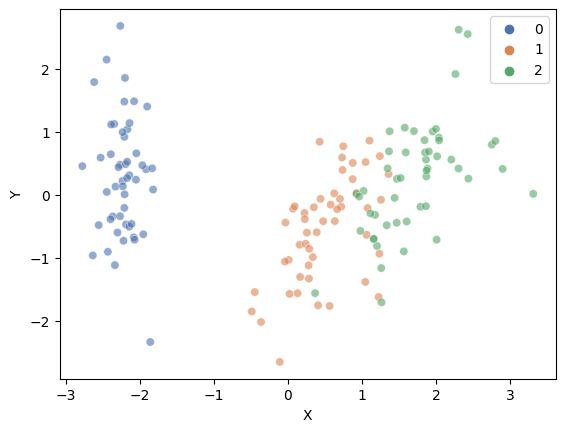

In [335]:
from sklearn.datasets import load_iris

# Carregando dataset Iris
iris = load_iris()

iris_data = iris.data

# Normalizando os dados
normalized_data = StandardScaler().fit_transform(iris_data)

pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)
iris_df = pd.DataFrame(data=components, columns=["X","Y"])

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
iris_df['Class'] = iris.target

plot_scatter(iris_df, 1)

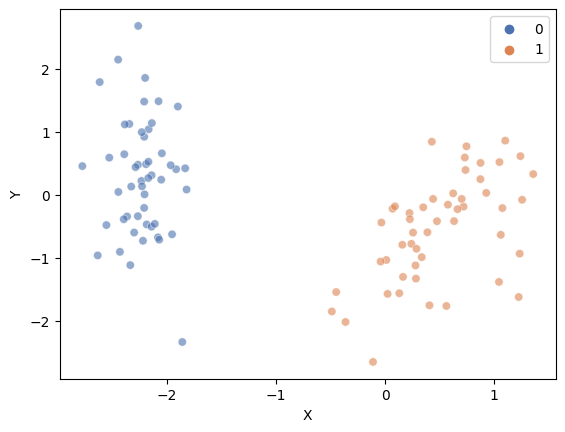

In [336]:
iris_filtered = iris_df[iris_df['Class'] != 2]

plot_scatter(iris_filtered, 1)

## Dataset Wine - Separável

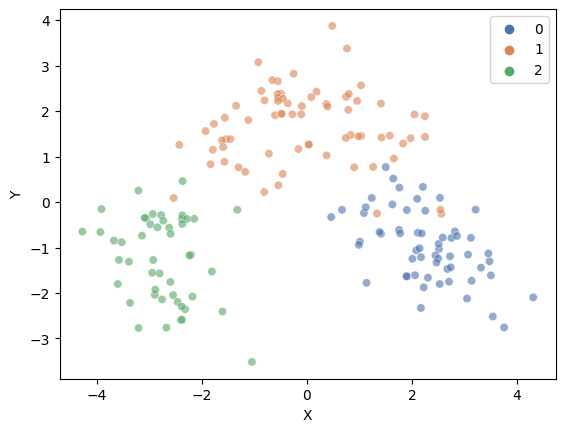

In [337]:
from sklearn.datasets import load_wine

wine = load_wine()
wine_data = wine.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(wine_data)
componentes = pca.fit_transform(normalized_data)
wine_df = pd.DataFrame(data=componentes, columns=["X","Y"])

wine_df['Class'] = wine.target

plot_scatter(wine_df, 1)

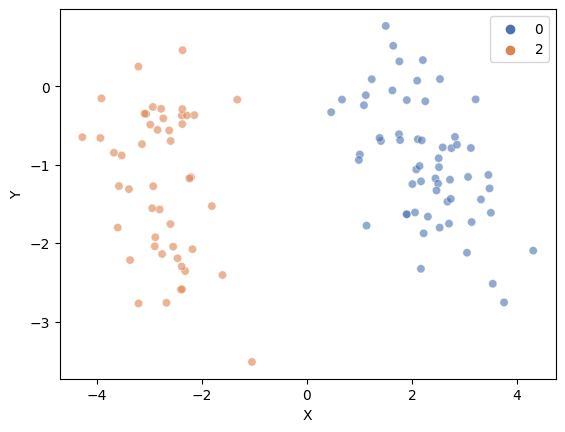

In [338]:
wine_filtered = wine_df[wine_df['Class'] != 1]

plot_scatter(wine_filtered, 1)

## Digits DataSet

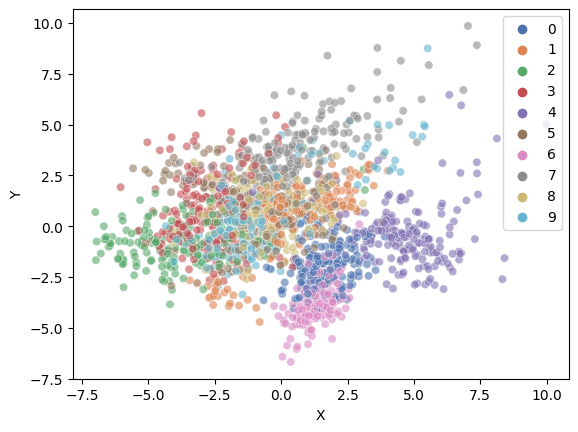

In [339]:
from sklearn.datasets import load_digits

digits = load_digits()
digits_data = digits.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(digits_data)
componentes = pca.fit_transform(normalized_data)
digits_df = pd.DataFrame(data=componentes, columns=["X","Y"])

digits_df['Class'] = digits.target

plot_scatter(digits_df, 1)

## Breast Cancer DataSet

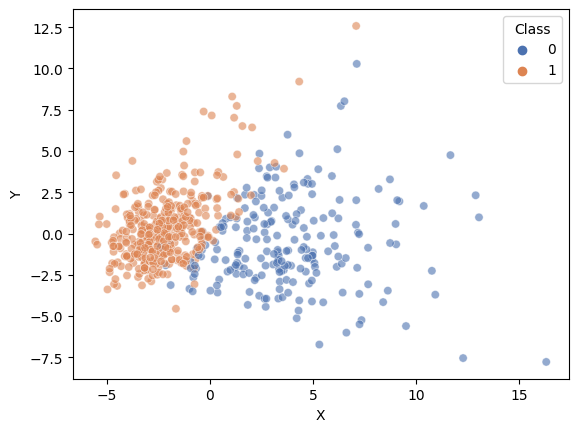

In [342]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
breast_cancer_data = breast_cancer.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(breast_cancer_data)
componentes = pca.fit_transform(normalized_data)
breast_cancer_df = pd.DataFrame(data=componentes, columns=["X","Y"])

breast_cancer_df['Class'] = breast_cancer.target

plot_scatter(breast_cancer_df, 0)

In [345]:
from sklearn.datasets import load_fetch_olivetti_faces

olivetti_faces = load_fetch_olivetti_faces()
olivetti_faces = olivetti_faces.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(olivetti_faces)
componentes = pca.fit_transform(normalized_data)
olivetti_faces_df = pd.DataFrame(data=componentes, columns=["X","Y"])

olivetti_faces_df['Class'] = olivetti_faces.target

plot_scatter(olivetti_faces_df, 0)

array([[191.,  36.,  50.],
       [189.,  37.,  52.],
       [193.,  38.,  58.],
       [162.,  35.,  62.],
       [189.,  35.,  46.],
       [182.,  36.,  56.],
       [211.,  38.,  56.],
       [167.,  34.,  60.],
       [176.,  31.,  74.],
       [154.,  33.,  56.],
       [169.,  34.,  50.],
       [166.,  33.,  52.],
       [154.,  34.,  64.],
       [247.,  46.,  50.],
       [193.,  36.,  46.],
       [202.,  37.,  62.],
       [176.,  37.,  54.],
       [157.,  32.,  52.],
       [156.,  33.,  54.],
       [138.,  33.,  68.]])